# Backtesting the MACD Trading Strategy

* Moving Averages Convergence Divergence (MACD) is a widely used trading signal for detecting trend reversals. 
* By design, moving averages lag the underlying time series. As a result, the triggers from trading strategies based on moving averages are often delayed resulting in missed opportunities or even losses.
* MACD signal overcomes this drawback to some extend. The MACD signal is defined by <b>three</b> components -

1. MACD line:  Difference between a slower EWMA and a faster EWMA. 
2. Signal Line: EWMA of the MACD Line
3. MACD histogram: Difference between the MACD line and the Signal Line.

## The MACD Crossover Trading Strategy :

* The MACD crossover strategy triggers a <b>buy</b> signal when the <b>MACD line crosses above the MACD signal line</b>. 
* On the other hand, an <b>exit/short signal</b> is triggered when the <b>MACD line crosses below the MACD line</b>.

<img src='./images/macd_crossover_cover.png'>

In [25]:
import os
import sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import mplfinance as mpl
import numpy as np
import seaborn as sns


from notebook_utils import initialize_environment, print_heading, Color

initialize_environment()


from analytics.strategies.macd_crossover import MACDCrossOverStrategy, Trend
from analytics.studies.macd import MACD
from analytics.services.alpha_vantage import TimeInterval, AVTimeseries
from analytics.services.alpha_vantage_utils import OutputSize


cm = sns.light_palette("green", as_cmap=True)

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

# 3 simple steps to evaluate the MA strategy for any Ticker - 

1. Load the data. 
2. Compute and Annotate MACD crosover sessions
3. Visualize and Analyze the data to make an informed Decision

## Preflight -

* Let us start by looking up for the correct ticker symbol using Alpha vantage. 

In [26]:
# if you dont have an alpha vantage api_key get it from -
# https://www.alphavantage.co/support/#api-key
av_obj = AVTimeseries(api_key="<AV_API_KEY>")

search_keyword = "apple"

search_symbol_results_df = av_obj.get_symbol_search_results(
    search_keyword=search_keyword
)
search_symbol_results_df.style.background_gradient(cmap=cm)

,symbol,name,type,region,marketOpen,marketClose,timezone,currency,matchScore
0,APLE,Apple Hospitality REIT Inc,Equity,United States,09:30,16:00,UTC-04,USD,0.8889
1,AAPL,Apple Inc,Equity,United States,09:30,16:00,UTC-04,USD,0.7143
2,AAPL34.SAO,Apple Inc,Equity,Brazil/Sao Paolo,10:00,17:30,UTC-03,BRL,0.7143
3,APC.DEX,Apple Inc,Equity,XETRA,08:00,20:00,UTC+02,EUR,0.7143
4,APC.FRK,Apple Inc,Equity,Frankfurt,08:00,20:00,UTC+02,EUR,0.7143
5,AGPL,Apple Green Holding Inc,Equity,United States,09:30,16:00,UTC-04,USD,0.6667
6,APGN.LON,Applegreen plc,Equity,United Kingdom,08:00,16:30,UTC+01,GBP,0.5455
7,APRU,Apple Rush Company Inc,Equity,United States,09:30,16:00,UTC-04,USD,0.4444
8,500014.BSE,Apple Finance Limited,Equity,India/Bombay,09:15,15:30,UTC+5.5,INR,0.3846
9,603020.SHH,Apple Flavor Fragrance Group Company Ltd,Equity,Shanghai,09:30,15:00,UTC+08,CNY,0.2222


<IPython.core.display.Javascript object>

# 1.  Pick the correct symbol from search results

* From here on, we shall use symbol 'APPL' to demonstrate computation further. 

In [37]:
symbol = search_symbol_results_df["symbol"].iloc[1]
print(symbol)

# Lets grab daily for AAPL.

av_ticker_df = av_obj.get_daily_data(
    symbol=symbol,
    adjusted=True,
    last_ten_years_only=True,
    outputsize=OutputSize.FULL,
)
av_ticker_df.index = pd.to_datetime(av_ticker_df.index)
display(av_ticker_df.tail().style.background_gradient(cmap=cm))

AAPL


,open,high,low,close,adjusted close,volume,dividend amount,split coefficient
2021-03-22 00:00:00,120.330000,123.870000,120.260000,123.390000,123.390000,111912284.000000,0.000000,1.000000
2021-03-23 00:00:00,123.330000,124.240000,122.140000,122.540000,122.540000,95467142.000000,0.000000,1.000000
2021-03-24 00:00:00,122.820000,122.900000,120.065000,120.090000,120.090000,88530485.000000,0.000000,1.000000
2021-03-25 00:00:00,119.540000,121.660000,119.000000,120.590000,120.590000,98844681.000000,0.000000,1.000000
2021-03-26 00:00:00,120.350000,121.480000,118.920000,121.210000,121.210000,94071234.000000,0.000000,1.000000


<IPython.core.display.Javascript object>

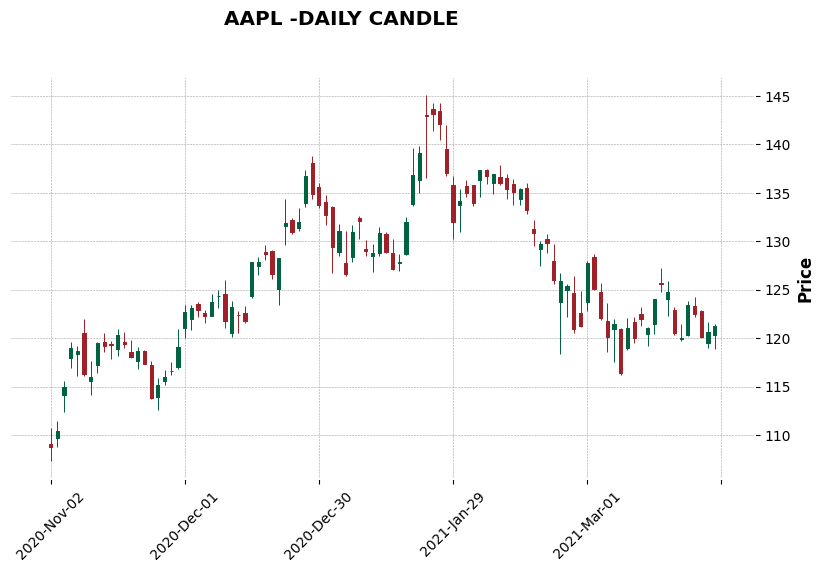

<IPython.core.display.Javascript object>

In [28]:
mpl.plot(
    av_ticker_df[-100:],
    type="candle",
    style="charles",
    figratio=(18, 10),
    title=f"{symbol} -DAILY CANDLE",
)

# 2. Compute Moving Averages Convergence Divergence (MACD) Crossover Sessions

In [38]:
# define slow and fast moving average look back periods
# Again, ensure that slow_ma > fast_ma
slow_ma = 26
fast_ma = 12
signal_line_period = 9
capture_trend = Trend.BULLISH

# create an instance of MACDCrossOverStrategy
macd_strategy_obj = MACDCrossOverStrategy(
    ticker_df=av_ticker_df,
    slow_ma=slow_ma,
    fast_ma=fast_ma,
    signal_line_period=signal_line_period,
)


# we can club the computation of MACD and annotattion using the macd_crossover_sessions() method.
macd_sessions_annotated_df = macd_strategy_obj.macd_crossover_sessions()

print_heading("MACD Cross Over Strategy Annotated Sessions")
display(
    macd_sessions_annotated_df[["close", "macd_line", "macd_signal", "label_macd"]]
    .tail(20)
    .style.background_gradient(cmap=cm)
)





###############################

MACD Cross Over Strategy Annotated Sessions

###############################


,close,macd_line,macd_signal,label_macd
2021-03-01 00:00:00,127.790000,-2.432740,-1.266541,bearish
2021-03-02 00:00:00,125.120000,-2.457604,-1.504754,bearish
2021-03-03 00:00:00,122.060000,-2.693180,-1.742439,bearish
2021-03-04 00:00:00,120.130000,-3.001016,-1.994154,bearish
2021-03-05 00:00:00,121.420000,-3.105093,-2.216342,bearish
2021-03-08 00:00:00,116.360000,-3.554896,-2.484053,bearish
2021-03-09 00:00:00,121.085000,-3.489871,-2.685216,bearish
2021-03-10 00:00:00,119.980000,-3.487302,-2.845634,bearish
2021-03-11 00:00:00,121.960000,-3.287600,-2.934027,bearish
2021-03-12 00:00:00,121.030000,-3.167861,-2.980794,bearish


<IPython.core.display.Javascript object>

## Visualize and Analyze data to make an informed decision

###############################

Returns Summary

###############################


,,percent_returns,session_details,number_of_sessions
macd_session,label_macd,,,
137,bullish,11.447619,2018-12-28 00:00:00-2019-03-05 00:00:00,45
139,bullish,4.705556,2019-03-12 00:00:00-2019-03-27 00:00:00,12
141,bullish,4.071380,2019-04-02 00:00:00-2019-04-12 00:00:00,9
143,bullish,1.063411,2019-04-18 00:00:00-2019-04-25 00:00:00,5
145,bullish,0.407796,2019-05-03 00:00:00-2019-05-03 00:00:00,1
147,bullish,11.699803,2019-06-06 00:00:00-2019-07-16 00:00:00,28
149,bullish,-0.014391,2019-07-23 00:00:00-2019-08-01 00:00:00,8
151,bullish,-1.960877,2019-08-19 00:00:00-2019-08-26 00:00:00,6
153,bullish,-0.675676,2019-08-30 00:00:00-2019-08-30 00:00:00,1


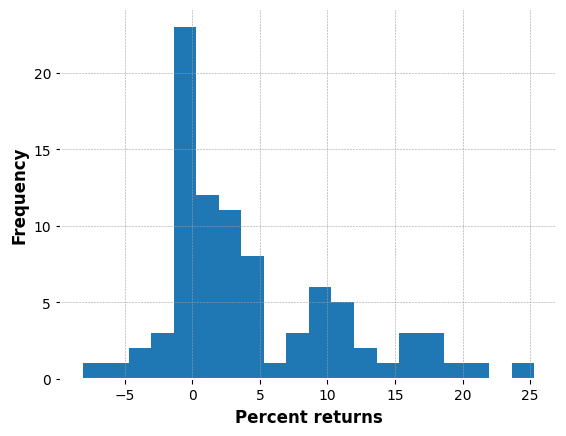

  Estimated Expected returns (%) - 4.447064185959004 % 


<IPython.core.display.Javascript object>

In [33]:
# use annotated sessions data to compute percentage returns
summary_df = macd_sessions_annotated_df.groupby(
    [f"macd_session", f"label_macd"], as_index=True
).apply(MACDCrossOverStrategy.compute_returns)

if capture_trend in {Trend.BULLISH, Trend.BEARISH}:
    summary_df = summary_df.loc[
        summary_df.index.get_level_values("label_macd") == capture_trend.value
    ]

print_heading("Returns Summary")

display(
    summary_df.tail(20).style.bar(
        subset=["percent_returns"], align="mid", color=["#d65f5f", "#5fba7d"]
    )
)

ax = summary_df.percent_returns.hist(bins=20)

ax.set_xlabel("Percent returns")
ax.set_ylabel("Frequency")

plt.show()

expected_returns = summary_df.percent_returns.mean()

color = Color.GREEN if expected_returns > 0 else Color.RED

print(
    f"{Color.BOLD} {color} Estimated Expected returns (%) - {expected_returns} % {Color.END}"
)